<a href="https://colab.research.google.com/github/RamAngothu/DEEP_LEARNING/blob/main/blood_vessel_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/archive (2).zip','r')
zip_ref.extractall('/content')
zip_ref.close()
zip_ref.close()

In [ ]:
IMAGE_PATH = "/content/Images"
MASK_PATH = "/content/Masks"


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 256  # Resize images for training

def load_images(folder, size=IMG_SIZE):
    images = []
    filenames = sorted(os.listdir(folder))  # Sorting to align with masks
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size)) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

def load_masks(folder, size=IMG_SIZE):
    masks = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        mask_path = os.path.join(folder, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (size, size)) / 255.0  # Normalize
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        masks.append(mask)
    return np.array(masks)

# Load dataset
images = load_images(IMAGE_PATH)
masks = load_masks(MASK_PATH)

print(f"Total Images: {len(images)}, Total Masks: {len(masks)}")


Total Images: 28, Total Masks: 28


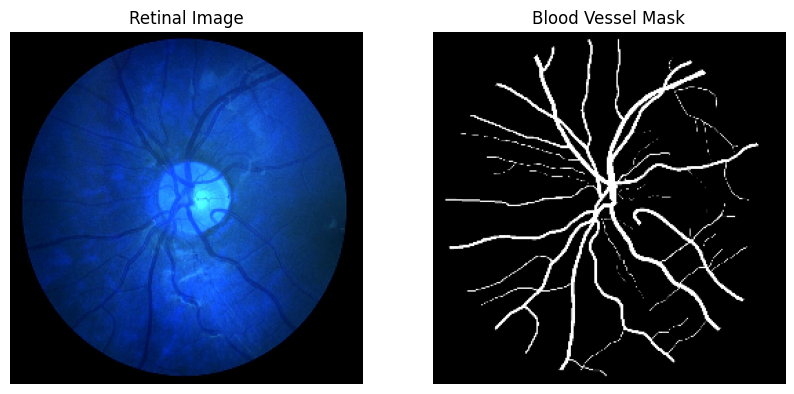

In [ ]:
idx = 2  # Change index to see different samples

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(images[idx])
plt.title("Retinal Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(masks[idx].squeeze(), cmap="gray")
plt.title("Blood Vessel Mask")
plt.axis("off")

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.models import Model


In [ ]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder (Downsampling)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Build U-Net model
unet = unet_model()
unet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 512)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras.backend as K

def dice_bce_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_loss = 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
    bce = K.binary_crossentropy(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice_loss  # Hybrid loss

unet.compile(optimizer='adam', loss=dice_bce_loss, metrics=['accuracy'])


In [ ]:
# Train U-Net
history = unet.fit(images, masks, epochs=40, batch_size=2, validation_split=0.2)


Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 308ms/step - accuracy: 0.9253 - loss: 0.3728 - val_accuracy: 0.9433 - val_loss: 0.2683
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9428 - loss: 0.2522 - val_accuracy: 0.9444 - val_loss: 0.2751
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9461 - loss: 0.2459 - val_accuracy: 0.9449 - val_loss: 0.2680
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9447 - loss: 0.2391 - val_accuracy: 0.9448 - val_loss: 0.2617
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9442 - loss: 0.2343 - val_accuracy: 0.9447 - val_loss: 0.2630
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9469 - loss: 0.2217 - val_accuracy: 0.9438 - val_loss: 0.2491
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9458 - loss: 0.2184 - val_accuracy: 0.9438 - val_loss: 0.2471
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9440 - loss: 0.2274 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


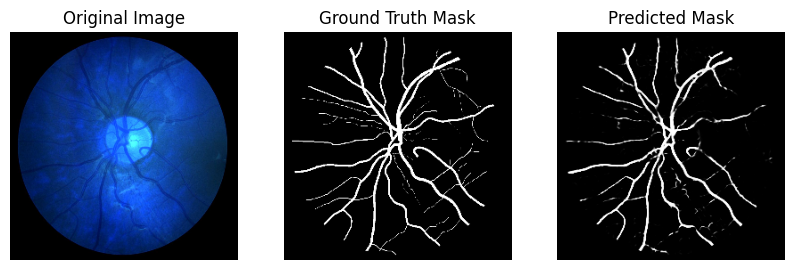

In [ ]:
# Predict on a test image
pred_mask = unet.predict(np.expand_dims(images[0], axis=0))[0]

# Show results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(images[0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(masks[0].squeeze(), cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


In [ ]:
unet.save('/content/unet_blood_vessel_segmentation.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model (make sure to give the correct file path)
model = load_model('/content/unet_blood_vessel_segmentation.h5', compile=False)  # Use the correct file name


In [ ]:
import cv2
import numpy as np
import os

IMG_SIZE = 256  # Ensure this matches what you used in training

def load_test_images(folder, size=IMG_SIZE):
    images = []
    filenames = sorted(os.listdir(folder))  # Ensure order consistency
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as RGB
        img = cv2.resize(img, (size, size))  # Resize to match model input
        img = img / 255.0  # Normalize
        images.append(img)
    return np.array(images)

# Define the folder where test images are stored
test_image_folder = '/content/Images'  # Update with the actual path
test_images = load_test_images(test_image_folder)

# Reshape to match model input shape
test_images = np.array(test_images).reshape(-1, IMG_SIZE, IMG_SIZE, 3)


In [ ]:
# Get predictions
predictions = model.predict(test_images)

# Convert predictions to binary masks (thresholding)
threshold = 0.5
predicted_masks = (predictions > threshold).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step


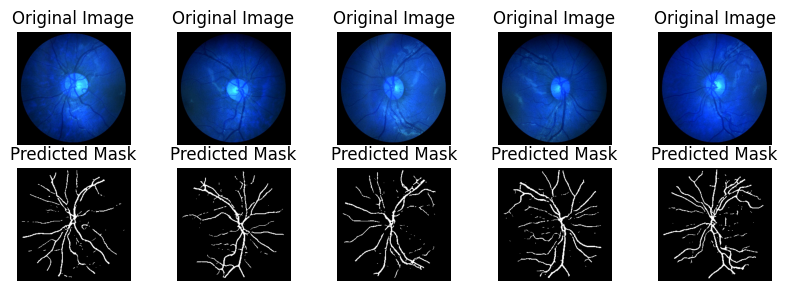

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(test_images, predicted_masks, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(test_images[i])
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(predicted_masks[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.show()

# Visualize results
visualize_results(test_images, predicted_masks)


In [ ]:
output_folder = "path_to_save_masks"
os.makedirs(output_folder, exist_ok=True)

for i, mask in enumerate(predicted_masks):
    save_path = os.path.join(output_folder, f"predicted_mask_{i+1}.png")
    cv2.imwrite(save_path, (mask.squeeze() * 255))  # Convert back to 0-255
